In [1]:

import numpy as np
import pydicom
import os
import sys
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence

print(tf.__version__)
print(keras.__version__)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import warnings
warnings.filterwarnings(action='once')
import cv2


2.8.1
2.8.0
Num GPUs Available:  1


In [2]:
import argparse
import os
import random as rn
import sys
from typing import Tuple

import numpy as np
import pandas as pd
import tensorflow as tf
from keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow import keras
import random

# import config
# from pe_logger import PELogger
# from plots.plot_results import (save_accuracy_plot, save_loss_plot,
#                                 save_pr_curve, save_roc_curve)
from inception_resnet_v2_gray import InceptionResNetV2Gray
# from training.slice_data_generator import SliceDataGenerator

# Set seeding based on Keras documentation
np.random.seed(1)
rn.seed(2)
tf.random.set_seed(3)

# logger = PELogger().get_logger()

# CONFIG = config.config()
# MODEL_DIR = CONFIG["model"]["model_dir"]
# PLOT_DIR = CONFIG["model"]["plot_dir"]
IMAGE_W = 386
IMAGE_H = 386
ENCODING_DIM = 64
FILENAME_COL = "png_filename"
LABEL_COL = "label"
FOLD_COL = "pat_fold"
EPOCHS = 3
BATCH_SIZE = 32
PRETRAINED_WEIGHTS = "./pretrained/InceptionResNetV2_NIH15_Px256.h5"
MODEL_DIR = '/home/shared/model_checkpoint_paige/singlescan-3channel/'


In [3]:
def get_model(num_channels: int) -> keras.models.Model:
    
    inputs = keras.Input(shape=(IMAGE_W,IMAGE_H,1))
    
    inception = InceptionResNetV2Gray(
                    input_shape=(IMAGE_H, IMAGE_W, 1),
                    include_top=False,
                    weights='pretrained/InceptionResNetV2_NIH15_Px256.h5',
                )
    x = inception(inputs)
    x = keras.layers.GlobalAveragePooling2D()(inception.output)
    x = keras.layers.Dense(512, activation="relu")(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(ENCODING_DIM)(x)
    x = keras.layers.Dense(1, activation="sigmoid")(x)
    model = keras.models.Model(inputs=inception.input, outputs=x)
    return model


def get_generators(
    df,
    fold,
):

    train_df = df[df.fold != fold].reset_index(drop=True)
    test_df = df[df.fold == fold].reset_index(drop=True)

    
    train_generator = DataSliceGenerator(train_df, 
                                   IMAGE_PATH, 
                                   img_type = IMG_TYPE,
                                   verbose=False, 
                                   n_channels=1, 
                                   set_type='train',
                                   batch_size=BATCH_SIZE,
                                   shuffle=True,
                                   dim=386)
    
    valid_generator = DataSliceGenerator(test_df, 
                                   IMAGE_PATH, 
                                   img_type = IMG_TYPE,
                                   verbose=False, 
                                   set_type = 'valid',
                                   n_channels=1, 
                                   batch_size=BATCH_SIZE,
                                   shuffle=False,
                                   dim=386)

    return train_generator, valid_generator


def train(
    df: pd.DataFrame,
    model_prefix: str,
    num_channels: int,
    pre_train_top: bool,
    fold: int,
):
    """Train a slice based (2D) binary classification model using Inception ResNet V2 backbone.
    Best model for given fold will be saved based validation loss.
    Args:
        df: dataframe object that contains list of images with labels and fold info
        image_dir: directory from which training images are loaded from
        model_prefix: prefix to use when storing trained models
        num_channels: number of input channels to use, 1 = NIH, 2 = ImageNet (RGB)
        pre_train_top: flag whether to first train a the classifier part
        fold: number indicating cross-validation fold
    """
    model = get_model(1)

    train_generator, valid_generator = get_generators(df, fold)

    opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, decay=0.01)

    training_histories = []
    os.makedirs(MODEL_DIR, exist_ok=True)
#     os.makedirs(PLOT_DIR, exist_ok=True)

    checkpoint_path = os.path.join(MODEL_DIR, f"{model_prefix}_fold_{fold:02d}.h5")
    check = keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        save_best_only=True,
        verbose=1,
    )


    for layer in model.layers:
        layer.trainable = True

    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    if fold == 0:
        model.summary()

    hist_full = model.fit(
        train_generator,
        epochs=EPOCHS,
        shuffle=False,
        validation_data=valid_generator,
        callbacks=[check],
    )

    training_histories.append(pd.DataFrame(hist_full.history))

    df_hist = pd.concat(training_histories, axis=0, ignore_index=True, sort=False)
    df_hist.to_csv(os.path.join(MODEL_DIR, f"hist_{model_prefix}_fold_{fold:02d}.csv"))




In [4]:
all_ids = pd.read_csv('all_ids_updated.csv')
all_ids = all_ids[all_ids.contains_lung == True].sample(frac=1).reset_index(drop=True)
all_ids.ycoord = all_ids.ycoord.replace('True', '1.0').astype('float')

/tmp/ipykernel_1627361/1656503385.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  all_ids = pd.read_csv('all_ids_updated.csv')


In [5]:
fold_df = pd.read_csv('folds.csv')
all_ids = pd.merge(all_ids, fold_df)

In [ ]:
BATCH_SIZE = 16
FOLDS = 10
EPOCHS = 3
MODEL_DIR = '/home/shared/model_checkpoint_paige/singlescan-3channel/'

fold = 6
# for fold in range(0, FOLDS):
#     if fold != 7 and fold != 8:
print(fold)
train(all_ids, 'turku-incepres', 1, True, fold)

6
Epoch 1/3
  808/10835 [=>............................] - ETA: 2:12:54 - loss: 0.5616 - accuracy: 0.7058

In [6]:
import turku_aug_funcs

class DataSliceGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, all_df, image_path, img_type, set_type, n_channels=1, 
                 batch_size=32, dim=386, num_pos=None, n_classes=2, shuffle=True,
                 verbose=False, to_fit=True,
                 ):
        """Initialization
        :param list_IDs: list of all 'label' ids to use in the generator
        :param labels: list of image labels (file names)
        :param image_path: path to images location
        :param mask_path: path to masks location
        :param to_fit: True to return X and y, False to return X only
        :param batch_size: batch size at each iteration
        :param dim: tuple indicating image dimension
        :param n_channels: number of image channels
        :param n_classes: number of output masks
        :param shuffle: True to shuffle label indexes after every epoch
        """
        self.image_path = image_path
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.path_dicom = image_path
        self.verbose = verbose
        self.img_type = img_type
        warnings.filterwarnings(action='ignore')
        self.all_df = all_df
        self.set_type = set_type
        
        if self.set_type == 'test':
            self.labels = self.all_df
        elif self.set_type == 'valid':
            pos = self.all_df[self.all_df.pe_present_on_image == True]
            neg = self.all_df[self.all_df.pe_present_on_image == False].sample(n=len(pos))
            self.labels = pd.concat([pos,neg]).sample(frac=1).reset_index(drop=True)
        elif self.set_type == 'train':
            pos = self.all_df[self.all_df.pe_present_on_image ==True]
            neg = self.all_df[self.all_df.pe_present_on_image == False].sample(n=len(pos))
            self.labels = pd.concat([pos,neg]).sample(frac=1).reset_index(drop=True)
        else:
            print('Invalid set type, must be test, valid or train')
            return False
        
        self.list_IDs = np.arange(len(self.labels))
        if self.shuffle == True:
            np.random.shuffle(self.list_IDs)

        
    def get_df(self):
        return self.labels

        
    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        
        indexes = self.list_IDs[index * self.batch_size:((index+1) * self.batch_size)]
        X = np.zeros([self.batch_size,self.dim,self.dim,1])
        y = np.zeros([self.batch_size, 1])
        for i in range(0,self.batch_size):
            X[i], y[i] = self._load_dicom(indexes[i])
            
        if self.verbose == True:
            fig, ax = plt.subplots(self.batch_size, 1, figsize=[12, 12*(self.batch_size/2)])
            for i in range(self.batch_size):
                ax[i].imshow(X[i])
                ax[i].axis('off')
        
        X = X/255
            
        if self.to_fit:
            return (X, y)
        else:
            return (X)
        
    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        if self.set_type == 'train':
            pos = self.all_df[self.all_df.pe_present_on_image ==True]
            neg = self.all_df[self.all_df.pe_present_on_image == False].sample(n=len(pos)*3)
            self.labels = pd.concat([pos,pos,pos,neg]).sample(frac=1).reset_index(drop=True)
            
        self.list_IDs = np.arange(len(self.labels))
        if self.shuffle == True:
            np.random.shuffle(self.list_IDs)

            
    def _load_dicom(self, index):
        slice = self.labels.iloc[index] 

        frame = cv2.imread(self.image_path+slice.StudyInstanceUID + '_'+ slice.SeriesInstanceUID
                      + '_' + slice.SOPInstanceUID +'.png')
        frame = frame[:,:,self.img_type]
        
#         frame = np.reshape(frame, (256,256,1))      
        
        if self.set_type == 'train':
            trans = random.sample(range(0,5),random.randint(0,5))
            if 0 in trans:
                frame = turku_aug_funcs.blur(frame)
            if 1 in trans:
                zoom = random.randint(0,2)
                if zoom == 0:
                    frame = turku_aug_funcs.zoom_1_05(frame)
                if zoom == 1:
                    frame = turku_aug_funcs.zoom_1_075(frame)
                if zoom == 2:
                    frame = turku_aug_funcs.zoom_1_15(frame)

            if 2 in trans:
                rot = random.randint(0,3)
                if rot == 0:
                    frame = turku_aug_funcs.rotate_3(frame)
                if rot == 1:
                    frame = turku_aug_funcs.rotate_m3(frame)
                if rot == 2:
                    frame = turku_aug_funcs.rotate_5(frame)
                if rot == 3:
                    frame = turku_aug_funcs.rotate_m5(frame)

            if 3 in trans:
                frame = np.reshape(frame, (1,256,256))
                frame = turku_aug_funcs.gaussian_noise(frame)
                frame = frame.squeeze()

            if 4 in trans:
                tx = random.randint(0,6)
                if tx == 0:
                    frame = turku_aug_funcs.tr_x10(frame)
                if tx == 1:
                    frame = turku_aug_funcs.tr_x15(frame)
                if tx == 2:
                    frame = turku_aug_funcs.tr_x20(frame)
                if tx == 3:
                    frame = turku_aug_funcs.tr_xm10(frame)
                if tx == 4:
                    frame = turku_aug_funcs.tr_xm15(frame)
                if tx == 5:
                    frame = turku_aug_funcs.tr_xm20(frame)
                tx = random.randint(0,6)
                if tx == 0:
                    frame = turku_aug_funcs.tr_y10(frame)
                if tx == 1:
                    frame = turku_aug_funcs.tr_y15(frame)
                if tx == 2:
                    frame = turku_aug_funcs.tr_y20(frame)
                if tx == 3:
                    frame = turku_aug_funcs.tr_ym10(frame)
                if tx == 4:
                    frame = turku_aug_funcs.tr_ym15(frame)
                if tx == 5:
                    frame = turku_aug_funcs.tr_ym20(frame)
        frame = cv2.resize(frame, (386,386))
        frame = np.reshape(frame, (386,386,1))
        
        if self.verbose == True:
            print(np.shape(frame))
            plt.imshow(frame)
            plt.show()

        frame = frame[None, ...]
        y = np.array([int(slice.pe_present_on_image)])
        y = y[None, ...]
        
        return frame, y

CROPPED = 0
MASKED = 1
ORIGINAL = 2

IMG_TYPE = MASKED
IMAGE_PATH = '/home/shared/nps/imgs/'


/home/jupyter-paige/turku_aug_funcs.py:3: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter
/home/jupyter-paige/turku_aug_funcs.py:4: DeprecationWarning: Please use `map_coordinates` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import map_coordinates


In [7]:
all_ids = pd.read_csv('all_ids_updated.csv')
all_ids = all_ids[all_ids.contains_lung == True].sample(frac=1).reset_index(drop=True)
all_ids.ycoord = all_ids.ycoord.replace('True', '1.0').astype('float')

all_ids_small = all_ids.drop(columns=['negative_exam_for_pe', 'qa_motion',
       'qa_contrast', 'flow_artifact', 'rv_lv_ratio_gte_1', 'rv_lv_ratio_lt_1',
       'leftsided_pe', 'chronic_pe', 'true_filling_defect_not_pe',
       'rightsided_pe', 'acute_and_chronic_pe', 'central_pe', 'indeterminate',
       'contains_lung'])

/tmp/ipykernel_1492292/1642990385.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  all_ids = pd.read_csv('all_ids_updated.csv')


In [8]:
model_partial = keras.models.Model(inputs=model.input, outputs=[model.layers[-2].output])
model_partial.summary()

NameError: name 'model' is not defined

In [58]:
import datetime

In [ ]:
unique_ids = all_ids_small.StudyInstanceUID.unique()

IMG_TYPE = MASKED
IMAGE_PATH = '/home/shared/nps/imgs/'

for i in range(0,len(unique_ids)):
    exam_id = unique_ids[i]
    exam = all_ids_small[all_ids_small.StudyInstanceUID == exam_id]
    exam = exam.sort_values(by='ycoord')
    exam_generator = DataSlabGenerator(np.arange(0, len(exam)),
                                   exam, 
                                   IMAGE_PATH, 
                                   img_type = IMG_TYPE,
                                   verbose=False, 
                                   shuffle=False,
                                   n_channels=1, 
                                   batch_size=1,
                                   dim=386)
    
    x_test = np.zeros([len(exam),386,386,1])
    for j in range(0,len(exam)):
        x_test[j],_ = exam_generator.__getitem__(j)
   
    preds = np.zeros([len(exam),1])
    feats = np.zeros([len(exam),64])
    for j in range(int(len(exam)/64)):
        preds[j*64:(j+1)*64] = model(x_test[j*64:(j+1)*64])
        feats[j*64:(j+1)*64] = np.array(model_partial(x_test[j*64:(j+1)*64]))
    if len(exam)%64 != 0:
        preds[(j+1)*64:] = model(x_test[(j+1)*64:])
        feats[(j+1)*64:] = np.array(model_partial(x_test[(j+1)*64:]))
        
    exam['pred'] = preds
    exam['features'] = feats.tolist()
    
    np.save('/home/shared/nps/turku_nps/' + exam_id, exam.to_dict(orient='records'))
    if i %10 == 0:
        print(i, 'time is: ', datetime.datetime.now())
        gc.collect()

0 time is:  2022-10-09 17:21:48.965489
10 time is:  2022-10-09 17:23:43.074357
20 time is:  2022-10-09 17:25:34.837636
30 time is:  2022-10-09 17:27:08.002715
40 time is:  2022-10-09 17:28:38.794697
50 time is:  2022-10-09 17:30:01.889690
60 time is:  2022-10-09 17:31:19.464497
70 time is:  2022-10-09 17:32:52.569585
80 time is:  2022-10-09 17:34:17.136675
90 time is:  2022-10-09 17:35:25.225675
100 time is:  2022-10-09 17:36:41.543218
110 time is:  2022-10-09 17:38:13.101969
120 time is:  2022-10-09 17:39:30.769572
130 time is:  2022-10-09 17:41:02.771900
140 time is:  2022-10-09 17:42:08.398016
150 time is:  2022-10-09 17:43:39.983429
160 time is:  2022-10-09 17:44:48.065302
170 time is:  2022-10-09 17:46:16.261212
180 time is:  2022-10-09 17:47:47.058817
190 time is:  2022-10-09 17:49:06.159406
200 time is:  2022-10-09 17:50:41.998120
210 time is:  2022-10-09 17:51:49.363953
220 time is:  2022-10-09 17:53:02.008974
230 time is:  2022-10-09 17:54:31.213327
240 time is:  2022-10-09 17

In [4]:
all_ids = pd.read_csv('all_ids_updated.csv')
all_ids.ycoord = all_ids.ycoord.replace('True', '1.0').astype('float')
train_ids = pd.read_csv('train_df_upd.csv').drop(columns='Unnamed: 0')
test_ids = pd.read_csv('test_df_upd.csv').drop(columns='Unnamed: 0')
val_ids = pd.read_csv('val_df_upd.csv').drop(columns='Unnamed: 0')

import os 
lisdir = os.listdir('/home/shared/nps/turku_nps/')
print(len(lisdir))

/tmp/ipykernel_345789/585394138.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  all_ids = pd.read_csv('all_ids_updated.csv')


6805


In [5]:
files = pd.DataFrame({'file_name':lisdir})
files['StudyInstanceUID'] = files['file_name'].str.replace('.npy','')

/tmp/ipykernel_345789/1352226058.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  files['StudyInstanceUID'] = files['file_name'].str.replace('.npy','')


In [6]:
test_ids = test_ids[test_ids.StudyInstanceUID.isin(files.StudyInstanceUID)]
train_ids = train_ids[train_ids.StudyInstanceUID.isin(files.StudyInstanceUID)]
val_ids = val_ids[val_ids.StudyInstanceUID.isin(files.StudyInstanceUID)]

In [7]:
train_ids.negative_exam_for_pe.mean(), 1-train_ids.negative_exam_for_pe.mean()

(0.6726179289607217, 0.3273820710392783)

In [8]:
train_ids_pos = train_ids[train_ids.negative_exam_for_pe == False]
train_ids_neg = train_ids[train_ids.negative_exam_for_pe == True]
train_ids_b = pd.concat([train_ids_pos, train_ids_pos, train_ids_neg,
                         train_ids_pos.sample(n = len(train_ids_neg)%len(train_ids_pos))])

In [9]:
val_ids_pos = val_ids[val_ids.negative_exam_for_pe == False]
val_ids_neg = val_ids[val_ids.negative_exam_for_pe == True]
val_ids_b = pd.concat([val_ids_pos, val_ids_neg.sample(n=len(val_ids_pos))])

In [10]:
num_features = 64
MAX_SEQ_LENGTH = 96


class DataGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, list_IDs, study_ids, num_features,
                 seq_length, return_type = 'both', to_fit=True, batch_size=32, 
                 shuffle=True, resample=False, full_set = None, random=False):

        self.list_IDs = list_IDs
        self.study_ids = study_ids
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_features = num_features
        self.seq_length = seq_length
        self.resample = resample
        self.full_set = full_set
        self.return_type = return_type
        self.random = random
        warnings.filterwarnings(action='ignore')
        self.on_epoch_end()

        
    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))


    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
#         print('starting')
        indexes = self.list_IDs[index * self.batch_size:((index+1) * self.batch_size)]
        X = np.zeros([self.batch_size, self.seq_length, self.num_features])
        y_seq = np.zeros([self.batch_size, self.seq_length, 1])
        y_tot = np.zeros([self.batch_size, 1])
        for i in range(0,self.batch_size):
            x, y = self._get_scan_data(self.study_ids.iloc[indexes[i]].StudyInstanceUID)
            X[i] = x
            y_seq[i] = y[0]
            y_tot[i] = y[1]
            
        if self.to_fit:
            if self.return_type =='both':
                return (X, [y_seq, y_tot])
            elif self.return_type == 'seq':
                return (X, y_seq)
            elif self.return_type == 'tot':
                return (X, y_tot)
            else:
                print('valid return types are both, seq and tot')
                return False
        else:
            return (X)
        
    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        if self.shuffle == True:
            np.random.shuffle(self.list_IDs)
            
    def _get_scan_data(self, study_id):
        scan = pd.DataFrame(np.load('/home/shared/nps/turku_nps/' +study_id + '.npy', allow_pickle=True).tolist())
        scan.ycoord = scan.ycoord.replace('True', '1.0').astype('float')
        scan = scan.sort_values(by=['ycoord'])
        
        features = scan.features.tolist()
        seq = scan.pe_present_on_image.tolist()
        seq = np.reshape(seq, [len(seq),1])
        tot = self.study_ids[self.study_ids.StudyInstanceUID == study_id].negative_exam_for_pe.iloc[0]
                    
        if len(features)>=self.seq_length:
            xs = (np.array(features)[:96]).tolist()
            ys = seq[:96]
        else:
            xs = np.zeros([self.seq_length, self.num_features])
            ys = np.zeros([self.seq_length, 1])
            
            xs[:len(features)] = features
            ys[:len(features)] = seq
        
        ys = ys.tolist()
        
        return (xs, [ys, tot])





training_generator = DataGenerator(np.arange(0,len(train_ids_b)), 
                                   train_ids_b,
                                   num_features, 
                                   96, 
                                   batch_size = 16)
validation_generator = DataGenerator(np.arange(0,len(val_ids_b)), 
                                     val_ids_b,
                                     num_features, 
                                     96, 
                                     batch_size = 16)
test_generator = DataGenerator(np.arange(0,len(test_ids)), 
                               test_ids, 
                               num_features, 
                               96, 
                               batch_size = 16)


In [13]:
def get_turku_lstm(seq_len, dim):
        inputs = keras.Input(shape=(seq_len, dim))
        x = layers.BatchNormalization()(inputs)
        x = layers.Bidirectional(layers.LSTM(units=64, return_sequences=True))(x)
        x = layers.TimeDistributed(layers.Dense(512, activation='relu'))(x)
        x = layers.TimeDistributed(layers.Dense(128, activation='relu'))(x)
        slice_outputs = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'), name='seq_out')(x)
        
        reshaped_features = layers.Reshape((seq_len,))(slice_outputs)
        reshaped_features = layers.Dropout(0.5)(reshaped_features)
        stack_outputs = layers.Dense(1, activation='sigmoid', name='tot_out')(reshaped_features)
        
        model = keras.models.Model(inputs=inputs, outputs=[slice_outputs, stack_outputs])
        
        return model

In [14]:
from keras import layers

In [ ]:

checkpoint_filepath = '/home/shared/model_checkpoint_paige/turku/lstm_sm'


opt = keras.optimizers.Nadam(learning_rate=0.001)
model = get_turku_lstm(96,64)
model.compile(loss="binary_crossentropy", optimizer = opt, metrics=['accuracy'])

mc = keras.callbacks.ModelCheckpoint(checkpoint_filepath, 
                                     monitor='val_loss', 
                                     verbose=1)

history = model.fit(
                    training_generator,
                    epochs=24,
                    validation_data=validation_generator,
                    callbacks=[mc])

2022-10-11 14:16:22.924354: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-11 14:16:23.516902: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10795 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:05:00.0, compute capability: 6.1


Epoch 1/24


2022-10-11 14:16:28.826027: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401


447/447 [==============================] - ETA: 0s - loss: 0.7059 - seq_out_loss: 0.1747 - tot_out_loss: 0.5312 - seq_out_accuracy: 0.9362 - tot_out_accuracy: 0.7596
Epoch 1: saving model to /home/shared/model_checkpoint_paige/turku/lstm_sm


2022-10-11 14:17:27.189376: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


447/447 [==============================] - 69s 144ms/step - loss: 0.7059 - seq_out_loss: 0.1747 - tot_out_loss: 0.5312 - seq_out_accuracy: 0.9362 - tot_out_accuracy: 0.7596 - val_loss: 0.6668 - val_seq_out_loss: 0.1942 - val_tot_out_loss: 0.4726 - val_seq_out_accuracy: 0.9288 - val_tot_out_accuracy: 0.8333
Epoch 2/24
447/447 [==============================] - ETA: 0s - loss: 0.6313 - seq_out_loss: 0.1654 - tot_out_loss: 0.4659 - seq_out_accuracy: 0.9404 - tot_out_accuracy: 0.8104
Epoch 2: saving model to /home/shared/model_checkpoint_paige/turku/lstm_sm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


447/447 [==============================] - 63s 141ms/step - loss: 0.6313 - seq_out_loss: 0.1654 - tot_out_loss: 0.4659 - seq_out_accuracy: 0.9404 - tot_out_accuracy: 0.8104 - val_loss: 0.6400 - val_seq_out_loss: 0.1912 - val_tot_out_loss: 0.4488 - val_seq_out_accuracy: 0.9341 - val_tot_out_accuracy: 0.8356
Epoch 3/24
447/447 [==============================] - ETA: 0s - loss: 0.5992 - seq_out_loss: 0.1619 - tot_out_loss: 0.4373 - seq_out_accuracy: 0.9405 - tot_out_accuracy: 0.8161
Epoch 3: saving model to /home/shared/model_checkpoint_paige/turku/lstm_sm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


447/447 [==============================] - 63s 142ms/step - loss: 0.5992 - seq_out_loss: 0.1619 - tot_out_loss: 0.4373 - seq_out_accuracy: 0.9405 - tot_out_accuracy: 0.8161 - val_loss: 0.6180 - val_seq_out_loss: 0.1943 - val_tot_out_loss: 0.4238 - val_seq_out_accuracy: 0.9288 - val_tot_out_accuracy: 0.8333
Epoch 4/24
447/447 [==============================] - ETA: 0s - loss: 0.5836 - seq_out_loss: 0.1609 - tot_out_loss: 0.4227 - seq_out_accuracy: 0.9406 - tot_out_accuracy: 0.8191
Epoch 4: saving model to /home/shared/model_checkpoint_paige/turku/lstm_sm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


447/447 [==============================] - 63s 141ms/step - loss: 0.5836 - seq_out_loss: 0.1609 - tot_out_loss: 0.4227 - seq_out_accuracy: 0.9406 - tot_out_accuracy: 0.8191 - val_loss: 0.6040 - val_seq_out_loss: 0.1937 - val_tot_out_loss: 0.4103 - val_seq_out_accuracy: 0.9296 - val_tot_out_accuracy: 0.8333
Epoch 5/24
447/447 [==============================] - ETA: 0s - loss: 0.5705 - seq_out_loss: 0.1586 - tot_out_loss: 0.4119 - seq_out_accuracy: 0.9419 - tot_out_accuracy: 0.8216
Epoch 5: saving model to /home/shared/model_checkpoint_paige/turku/lstm_sm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


447/447 [==============================] - 63s 141ms/step - loss: 0.5705 - seq_out_loss: 0.1586 - tot_out_loss: 0.4119 - seq_out_accuracy: 0.9419 - tot_out_accuracy: 0.8216 - val_loss: 0.5920 - val_seq_out_loss: 0.1872 - val_tot_out_loss: 0.4049 - val_seq_out_accuracy: 0.9298 - val_tot_out_accuracy: 0.8356
Epoch 6/24
447/447 [==============================] - ETA: 0s - loss: 0.5629 - seq_out_loss: 0.1574 - tot_out_loss: 0.4056 - seq_out_accuracy: 0.9424 - tot_out_accuracy: 0.8245
Epoch 6: saving model to /home/shared/model_checkpoint_paige/turku/lstm_sm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


447/447 [==============================] - 64s 143ms/step - loss: 0.5629 - seq_out_loss: 0.1574 - tot_out_loss: 0.4056 - seq_out_accuracy: 0.9424 - tot_out_accuracy: 0.8245 - val_loss: 0.5890 - val_seq_out_loss: 0.1838 - val_tot_out_loss: 0.4052 - val_seq_out_accuracy: 0.9321 - val_tot_out_accuracy: 0.8426
Epoch 7/24
447/447 [==============================] - ETA: 0s - loss: 0.5564 - seq_out_loss: 0.1566 - tot_out_loss: 0.3998 - seq_out_accuracy: 0.9420 - tot_out_accuracy: 0.8228
Epoch 7: saving model to /home/shared/model_checkpoint_paige/turku/lstm_sm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


447/447 [==============================] - 63s 142ms/step - loss: 0.5564 - seq_out_loss: 0.1566 - tot_out_loss: 0.3998 - seq_out_accuracy: 0.9420 - tot_out_accuracy: 0.8228 - val_loss: 0.5874 - val_seq_out_loss: 0.1839 - val_tot_out_loss: 0.4034 - val_seq_out_accuracy: 0.9312 - val_tot_out_accuracy: 0.8380
Epoch 8/24
447/447 [==============================] - ETA: 0s - loss: 0.5511 - seq_out_loss: 0.1559 - tot_out_loss: 0.3952 - seq_out_accuracy: 0.9419 - tot_out_accuracy: 0.8259
Epoch 8: saving model to /home/shared/model_checkpoint_paige/turku/lstm_sm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


447/447 [==============================] - 64s 142ms/step - loss: 0.5511 - seq_out_loss: 0.1559 - tot_out_loss: 0.3952 - seq_out_accuracy: 0.9419 - tot_out_accuracy: 0.8259 - val_loss: 0.5939 - val_seq_out_loss: 0.1987 - val_tot_out_loss: 0.3952 - val_seq_out_accuracy: 0.9282 - val_tot_out_accuracy: 0.8310
Epoch 9/24
447/447 [==============================] - ETA: 0s - loss: 0.5477 - seq_out_loss: 0.1561 - tot_out_loss: 0.3915 - seq_out_accuracy: 0.9415 - tot_out_accuracy: 0.8273
Epoch 9: saving model to /home/shared/model_checkpoint_paige/turku/lstm_sm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


447/447 [==============================] - 64s 142ms/step - loss: 0.5477 - seq_out_loss: 0.1561 - tot_out_loss: 0.3915 - seq_out_accuracy: 0.9415 - tot_out_accuracy: 0.8273 - val_loss: 0.5841 - val_seq_out_loss: 0.1902 - val_tot_out_loss: 0.3939 - val_seq_out_accuracy: 0.9317 - val_tot_out_accuracy: 0.8333
Epoch 10/24
447/447 [==============================] - ETA: 0s - loss: 0.5458 - seq_out_loss: 0.1544 - tot_out_loss: 0.3914 - seq_out_accuracy: 0.9419 - tot_out_accuracy: 0.8286
Epoch 10: saving model to /home/shared/model_checkpoint_paige/turku/lstm_sm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


447/447 [==============================] - 64s 142ms/step - loss: 0.5458 - seq_out_loss: 0.1544 - tot_out_loss: 0.3914 - seq_out_accuracy: 0.9419 - tot_out_accuracy: 0.8286 - val_loss: 0.5833 - val_seq_out_loss: 0.1928 - val_tot_out_loss: 0.3905 - val_seq_out_accuracy: 0.9311 - val_tot_out_accuracy: 0.8380
Epoch 11/24
447/447 [==============================] - ETA: 0s - loss: 0.5411 - seq_out_loss: 0.1544 - tot_out_loss: 0.3867 - seq_out_accuracy: 0.9425 - tot_out_accuracy: 0.8300
Epoch 11: saving model to /home/shared/model_checkpoint_paige/turku/lstm_sm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


447/447 [==============================] - 64s 142ms/step - loss: 0.5411 - seq_out_loss: 0.1544 - tot_out_loss: 0.3867 - seq_out_accuracy: 0.9425 - tot_out_accuracy: 0.8300 - val_loss: 0.5692 - val_seq_out_loss: 0.1871 - val_tot_out_loss: 0.3820 - val_seq_out_accuracy: 0.9301 - val_tot_out_accuracy: 0.8449
Epoch 12/24
447/447 [==============================] - ETA: 0s - loss: 0.5398 - seq_out_loss: 0.1559 - tot_out_loss: 0.3839 - seq_out_accuracy: 0.9412 - tot_out_accuracy: 0.8324
Epoch 12: saving model to /home/shared/model_checkpoint_paige/turku/lstm_sm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


447/447 [==============================] - 63s 142ms/step - loss: 0.5398 - seq_out_loss: 0.1559 - tot_out_loss: 0.3839 - seq_out_accuracy: 0.9412 - tot_out_accuracy: 0.8324 - val_loss: 0.5727 - val_seq_out_loss: 0.1874 - val_tot_out_loss: 0.3853 - val_seq_out_accuracy: 0.9314 - val_tot_out_accuracy: 0.8356
Epoch 13/24
447/447 [==============================] - ETA: 0s - loss: 0.5358 - seq_out_loss: 0.1537 - tot_out_loss: 0.3821 - seq_out_accuracy: 0.9426 - tot_out_accuracy: 0.8319
Epoch 13: saving model to /home/shared/model_checkpoint_paige/turku/lstm_sm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


447/447 [==============================] - 64s 143ms/step - loss: 0.5358 - seq_out_loss: 0.1537 - tot_out_loss: 0.3821 - seq_out_accuracy: 0.9426 - tot_out_accuracy: 0.8319 - val_loss: 0.5823 - val_seq_out_loss: 0.1886 - val_tot_out_loss: 0.3937 - val_seq_out_accuracy: 0.9325 - val_tot_out_accuracy: 0.8380
Epoch 14/24
447/447 [==============================] - ETA: 0s - loss: 0.5257 - seq_out_loss: 0.1531 - tot_out_loss: 0.3726 - seq_out_accuracy: 0.9431 - tot_out_accuracy: 0.8386
Epoch 14: saving model to /home/shared/model_checkpoint_paige/turku/lstm_sm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


447/447 [==============================] - 64s 143ms/step - loss: 0.5257 - seq_out_loss: 0.1531 - tot_out_loss: 0.3726 - seq_out_accuracy: 0.9431 - tot_out_accuracy: 0.8386 - val_loss: 0.5902 - val_seq_out_loss: 0.1982 - val_tot_out_loss: 0.3920 - val_seq_out_accuracy: 0.9288 - val_tot_out_accuracy: 0.8356
Epoch 15/24
447/447 [==============================] - ETA: 0s - loss: 0.5246 - seq_out_loss: 0.1526 - tot_out_loss: 0.3721 - seq_out_accuracy: 0.9423 - tot_out_accuracy: 0.8385
Epoch 15: saving model to /home/shared/model_checkpoint_paige/turku/lstm_sm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


447/447 [==============================] - 64s 143ms/step - loss: 0.5246 - seq_out_loss: 0.1526 - tot_out_loss: 0.3721 - seq_out_accuracy: 0.9423 - tot_out_accuracy: 0.8385 - val_loss: 0.5819 - val_seq_out_loss: 0.1933 - val_tot_out_loss: 0.3885 - val_seq_out_accuracy: 0.9298 - val_tot_out_accuracy: 0.8310
Epoch 16/24
447/447 [==============================] - ETA: 0s - loss: 0.5239 - seq_out_loss: 0.1523 - tot_out_loss: 0.3716 - seq_out_accuracy: 0.9427 - tot_out_accuracy: 0.8346
Epoch 16: saving model to /home/shared/model_checkpoint_paige/turku/lstm_sm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


447/447 [==============================] - 64s 142ms/step - loss: 0.5239 - seq_out_loss: 0.1523 - tot_out_loss: 0.3716 - seq_out_accuracy: 0.9427 - tot_out_accuracy: 0.8346 - val_loss: 0.5893 - val_seq_out_loss: 0.1963 - val_tot_out_loss: 0.3929 - val_seq_out_accuracy: 0.9312 - val_tot_out_accuracy: 0.8356
Epoch 17/24
447/447 [==============================] - ETA: 0s - loss: 0.5125 - seq_out_loss: 0.1518 - tot_out_loss: 0.3608 - seq_out_accuracy: 0.9435 - tot_out_accuracy: 0.8399
Epoch 17: saving model to /home/shared/model_checkpoint_paige/turku/lstm_sm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


447/447 [==============================] - 64s 143ms/step - loss: 0.5125 - seq_out_loss: 0.1518 - tot_out_loss: 0.3608 - seq_out_accuracy: 0.9435 - tot_out_accuracy: 0.8399 - val_loss: 0.5964 - val_seq_out_loss: 0.1939 - val_tot_out_loss: 0.4025 - val_seq_out_accuracy: 0.9303 - val_tot_out_accuracy: 0.8333
Epoch 18/24
447/447 [==============================] - ETA: 0s - loss: 0.5073 - seq_out_loss: 0.1516 - tot_out_loss: 0.3558 - seq_out_accuracy: 0.9433 - tot_out_accuracy: 0.8454
Epoch 18: saving model to /home/shared/model_checkpoint_paige/turku/lstm_sm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


447/447 [==============================] - 64s 143ms/step - loss: 0.5073 - seq_out_loss: 0.1516 - tot_out_loss: 0.3558 - seq_out_accuracy: 0.9433 - tot_out_accuracy: 0.8454 - val_loss: 0.6060 - val_seq_out_loss: 0.1902 - val_tot_out_loss: 0.4158 - val_seq_out_accuracy: 0.9307 - val_tot_out_accuracy: 0.8264
Epoch 19/24
447/447 [==============================] - ETA: 0s - loss: 0.5082 - seq_out_loss: 0.1505 - tot_out_loss: 0.3577 - seq_out_accuracy: 0.9438 - tot_out_accuracy: 0.8440
Epoch 19: saving model to /home/shared/model_checkpoint_paige/turku/lstm_sm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm_sm/assets


447/447 [==============================] - 64s 143ms/step - loss: 0.5082 - seq_out_loss: 0.1505 - tot_out_loss: 0.3577 - seq_out_accuracy: 0.9438 - tot_out_accuracy: 0.8440 - val_loss: 0.5934 - val_seq_out_loss: 0.1895 - val_tot_out_loss: 0.4039 - val_seq_out_accuracy: 0.9327 - val_tot_out_accuracy: 0.8380
Epoch 20/24
 56/447 [==>...........................] - ETA: 45s - loss: 0.5120 - seq_out_loss: 0.1513 - tot_out_loss: 0.3607 - seq_out_accuracy: 0.9418 - tot_out_accuracy: 0.8415

In [42]:

checkpoint_filepath = '/home/shared/model_checkpoint_paige/turku/lstm'


opt = keras.optimizers.Nadam(learning_rate=0.001)
model = get_turku_lstm(200,64)
model.compile(loss="binary_crossentropy", optimizer = opt, metrics=['accuracy'])

mc = keras.callbacks.ModelCheckpoint(checkpoint_filepath, 
                                     monitor='val_loss', 
                                     verbose=1)

history = model.fit(
                    training_generator,
                    epochs=24,
                    validation_data=validation_generator,
                    callbacks=[mc])

2022-10-11 12:45:54.861934: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-11 12:45:55.592664: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11470 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:06:00.0, compute capability: 5.2


Epoch 1/24
  1/447 [..............................] - ETA: 33:52 - loss: 1.6875 - seq_out_loss: 0.6971 - tot_out_loss: 0.9904 - seq_out_accuracy: 0.4819 - tot_out_accuracy: 0.3750

2022-10-11 12:46:00.736262: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401


447/447 [==============================] - ETA: 0s - loss: 0.6448 - seq_out_loss: 0.1340 - tot_out_loss: 0.5108 - seq_out_accuracy: 0.9535 - tot_out_accuracy: 0.7781
Epoch 1: saving model to /home/shared/model_checkpoint_paige/turku/lstm


2022-10-11 12:46:52.214757: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


447/447 [==============================] - 62s 128ms/step - loss: 0.6448 - seq_out_loss: 0.1340 - tot_out_loss: 0.5108 - seq_out_accuracy: 0.9535 - tot_out_accuracy: 0.7781 - val_loss: 0.6103 - val_seq_out_loss: 0.1334 - val_tot_out_loss: 0.4769 - val_seq_out_accuracy: 0.9488 - val_tot_out_accuracy: 0.8056
Epoch 2/24
447/447 [==============================] - ETA: 0s - loss: 0.5608 - seq_out_loss: 0.1250 - tot_out_loss: 0.4358 - seq_out_accuracy: 0.9559 - tot_out_accuracy: 0.8365
Epoch 2: saving model to /home/shared/model_checkpoint_paige/turku/lstm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


447/447 [==============================] - 55s 124ms/step - loss: 0.5608 - seq_out_loss: 0.1250 - tot_out_loss: 0.4358 - seq_out_accuracy: 0.9559 - tot_out_accuracy: 0.8365 - val_loss: 0.5598 - val_seq_out_loss: 0.1320 - val_tot_out_loss: 0.4278 - val_seq_out_accuracy: 0.9558 - val_tot_out_accuracy: 0.8426
Epoch 3/24
447/447 [==============================] - ETA: 0s - loss: 0.5337 - seq_out_loss: 0.1267 - tot_out_loss: 0.4070 - seq_out_accuracy: 0.9559 - tot_out_accuracy: 0.8452
Epoch 3: saving model to /home/shared/model_checkpoint_paige/turku/lstm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


447/447 [==============================] - 56s 125ms/step - loss: 0.5337 - seq_out_loss: 0.1267 - tot_out_loss: 0.4070 - seq_out_accuracy: 0.9559 - tot_out_accuracy: 0.8452 - val_loss: 0.5406 - val_seq_out_loss: 0.1336 - val_tot_out_loss: 0.4070 - val_seq_out_accuracy: 0.9533 - val_tot_out_accuracy: 0.8426
Epoch 4/24
447/447 [==============================] - ETA: 0s - loss: 0.5068 - seq_out_loss: 0.1260 - tot_out_loss: 0.3808 - seq_out_accuracy: 0.9565 - tot_out_accuracy: 0.8438
Epoch 4: saving model to /home/shared/model_checkpoint_paige/turku/lstm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


447/447 [==============================] - 55s 124ms/step - loss: 0.5068 - seq_out_loss: 0.1260 - tot_out_loss: 0.3808 - seq_out_accuracy: 0.9565 - tot_out_accuracy: 0.8438 - val_loss: 0.5128 - val_seq_out_loss: 0.1356 - val_tot_out_loss: 0.3773 - val_seq_out_accuracy: 0.9510 - val_tot_out_accuracy: 0.8588
Epoch 5/24
447/447 [==============================] - ETA: 0s - loss: 0.4959 - seq_out_loss: 0.1269 - tot_out_loss: 0.3690 - seq_out_accuracy: 0.9558 - tot_out_accuracy: 0.8475
Epoch 5: saving model to /home/shared/model_checkpoint_paige/turku/lstm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


447/447 [==============================] - 57s 127ms/step - loss: 0.4959 - seq_out_loss: 0.1269 - tot_out_loss: 0.3690 - seq_out_accuracy: 0.9558 - tot_out_accuracy: 0.8475 - val_loss: 0.5194 - val_seq_out_loss: 0.1405 - val_tot_out_loss: 0.3788 - val_seq_out_accuracy: 0.9483 - val_tot_out_accuracy: 0.8449
Epoch 6/24
447/447 [==============================] - ETA: 0s - loss: 0.4864 - seq_out_loss: 0.1239 - tot_out_loss: 0.3625 - seq_out_accuracy: 0.9566 - tot_out_accuracy: 0.8501
Epoch 6: saving model to /home/shared/model_checkpoint_paige/turku/lstm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


447/447 [==============================] - 56s 125ms/step - loss: 0.4864 - seq_out_loss: 0.1239 - tot_out_loss: 0.3625 - seq_out_accuracy: 0.9566 - tot_out_accuracy: 0.8501 - val_loss: 0.5070 - val_seq_out_loss: 0.1361 - val_tot_out_loss: 0.3709 - val_seq_out_accuracy: 0.9492 - val_tot_out_accuracy: 0.8565
Epoch 7/24
447/447 [==============================] - ETA: 0s - loss: 0.4797 - seq_out_loss: 0.1254 - tot_out_loss: 0.3543 - seq_out_accuracy: 0.9562 - tot_out_accuracy: 0.8500
Epoch 7: saving model to /home/shared/model_checkpoint_paige/turku/lstm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


447/447 [==============================] - 57s 127ms/step - loss: 0.4797 - seq_out_loss: 0.1254 - tot_out_loss: 0.3543 - seq_out_accuracy: 0.9562 - tot_out_accuracy: 0.8500 - val_loss: 0.5134 - val_seq_out_loss: 0.1367 - val_tot_out_loss: 0.3767 - val_seq_out_accuracy: 0.9521 - val_tot_out_accuracy: 0.8565
Epoch 8/24
447/447 [==============================] - ETA: 0s - loss: 0.4752 - seq_out_loss: 0.1216 - tot_out_loss: 0.3535 - seq_out_accuracy: 0.9569 - tot_out_accuracy: 0.8487
Epoch 8: saving model to /home/shared/model_checkpoint_paige/turku/lstm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


447/447 [==============================] - 57s 128ms/step - loss: 0.4752 - seq_out_loss: 0.1216 - tot_out_loss: 0.3535 - seq_out_accuracy: 0.9569 - tot_out_accuracy: 0.8487 - val_loss: 0.5101 - val_seq_out_loss: 0.1312 - val_tot_out_loss: 0.3788 - val_seq_out_accuracy: 0.9543 - val_tot_out_accuracy: 0.8565
Epoch 9/24
447/447 [==============================] - ETA: 0s - loss: 0.4652 - seq_out_loss: 0.1211 - tot_out_loss: 0.3441 - seq_out_accuracy: 0.9570 - tot_out_accuracy: 0.8570
Epoch 9: saving model to /home/shared/model_checkpoint_paige/turku/lstm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


447/447 [==============================] - 56s 124ms/step - loss: 0.4652 - seq_out_loss: 0.1211 - tot_out_loss: 0.3441 - seq_out_accuracy: 0.9570 - tot_out_accuracy: 0.8570 - val_loss: 0.5083 - val_seq_out_loss: 0.1307 - val_tot_out_loss: 0.3776 - val_seq_out_accuracy: 0.9535 - val_tot_out_accuracy: 0.8519
Epoch 10/24
447/447 [==============================] - ETA: 0s - loss: 0.4676 - seq_out_loss: 0.1213 - tot_out_loss: 0.3463 - seq_out_accuracy: 0.9570 - tot_out_accuracy: 0.8518
Epoch 10: saving model to /home/shared/model_checkpoint_paige/turku/lstm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


447/447 [==============================] - 56s 125ms/step - loss: 0.4676 - seq_out_loss: 0.1213 - tot_out_loss: 0.3463 - seq_out_accuracy: 0.9570 - tot_out_accuracy: 0.8518 - val_loss: 0.5084 - val_seq_out_loss: 0.1350 - val_tot_out_loss: 0.3733 - val_seq_out_accuracy: 0.9530 - val_tot_out_accuracy: 0.8588
Epoch 11/24
447/447 [==============================] - ETA: 0s - loss: 0.4590 - seq_out_loss: 0.1195 - tot_out_loss: 0.3394 - seq_out_accuracy: 0.9574 - tot_out_accuracy: 0.8575
Epoch 11: saving model to /home/shared/model_checkpoint_paige/turku/lstm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


447/447 [==============================] - 55s 122ms/step - loss: 0.4590 - seq_out_loss: 0.1195 - tot_out_loss: 0.3394 - seq_out_accuracy: 0.9574 - tot_out_accuracy: 0.8575 - val_loss: 0.5008 - val_seq_out_loss: 0.1348 - val_tot_out_loss: 0.3660 - val_seq_out_accuracy: 0.9498 - val_tot_out_accuracy: 0.8472
Epoch 12/24
447/447 [==============================] - ETA: 0s - loss: 0.4575 - seq_out_loss: 0.1199 - tot_out_loss: 0.3376 - seq_out_accuracy: 0.9572 - tot_out_accuracy: 0.8584
Epoch 12: saving model to /home/shared/model_checkpoint_paige/turku/lstm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


447/447 [==============================] - 55s 123ms/step - loss: 0.4575 - seq_out_loss: 0.1199 - tot_out_loss: 0.3376 - seq_out_accuracy: 0.9572 - tot_out_accuracy: 0.8584 - val_loss: 0.5037 - val_seq_out_loss: 0.1353 - val_tot_out_loss: 0.3684 - val_seq_out_accuracy: 0.9531 - val_tot_out_accuracy: 0.8611
Epoch 13/24
447/447 [==============================] - ETA: 0s - loss: 0.4535 - seq_out_loss: 0.1196 - tot_out_loss: 0.3339 - seq_out_accuracy: 0.9574 - tot_out_accuracy: 0.8574
Epoch 13: saving model to /home/shared/model_checkpoint_paige/turku/lstm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


447/447 [==============================] - 57s 127ms/step - loss: 0.4535 - seq_out_loss: 0.1196 - tot_out_loss: 0.3339 - seq_out_accuracy: 0.9574 - tot_out_accuracy: 0.8574 - val_loss: 0.5026 - val_seq_out_loss: 0.1369 - val_tot_out_loss: 0.3657 - val_seq_out_accuracy: 0.9493 - val_tot_out_accuracy: 0.8588
Epoch 14/24
447/447 [==============================] - ETA: 0s - loss: 0.4511 - seq_out_loss: 0.1184 - tot_out_loss: 0.3327 - seq_out_accuracy: 0.9579 - tot_out_accuracy: 0.8606
Epoch 14: saving model to /home/shared/model_checkpoint_paige/turku/lstm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


447/447 [==============================] - 57s 126ms/step - loss: 0.4511 - seq_out_loss: 0.1184 - tot_out_loss: 0.3327 - seq_out_accuracy: 0.9579 - tot_out_accuracy: 0.8606 - val_loss: 0.5045 - val_seq_out_loss: 0.1390 - val_tot_out_loss: 0.3655 - val_seq_out_accuracy: 0.9492 - val_tot_out_accuracy: 0.8542
Epoch 15/24
447/447 [==============================] - ETA: 0s - loss: 0.4453 - seq_out_loss: 0.1186 - tot_out_loss: 0.3268 - seq_out_accuracy: 0.9577 - tot_out_accuracy: 0.8613
Epoch 15: saving model to /home/shared/model_checkpoint_paige/turku/lstm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


447/447 [==============================] - 57s 127ms/step - loss: 0.4453 - seq_out_loss: 0.1186 - tot_out_loss: 0.3268 - seq_out_accuracy: 0.9577 - tot_out_accuracy: 0.8613 - val_loss: 0.5013 - val_seq_out_loss: 0.1353 - val_tot_out_loss: 0.3660 - val_seq_out_accuracy: 0.9519 - val_tot_out_accuracy: 0.8542
Epoch 16/24
447/447 [==============================] - ETA: 0s - loss: 0.4437 - seq_out_loss: 0.1185 - tot_out_loss: 0.3252 - seq_out_accuracy: 0.9576 - tot_out_accuracy: 0.8619
Epoch 16: saving model to /home/shared/model_checkpoint_paige/turku/lstm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


447/447 [==============================] - 56s 125ms/step - loss: 0.4437 - seq_out_loss: 0.1185 - tot_out_loss: 0.3252 - seq_out_accuracy: 0.9576 - tot_out_accuracy: 0.8619 - val_loss: 0.4924 - val_seq_out_loss: 0.1330 - val_tot_out_loss: 0.3594 - val_seq_out_accuracy: 0.9527 - val_tot_out_accuracy: 0.8588
Epoch 17/24
447/447 [==============================] - ETA: 0s - loss: 0.4401 - seq_out_loss: 0.1178 - tot_out_loss: 0.3223 - seq_out_accuracy: 0.9576 - tot_out_accuracy: 0.8656
Epoch 17: saving model to /home/shared/model_checkpoint_paige/turku/lstm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


447/447 [==============================] - 58s 129ms/step - loss: 0.4401 - seq_out_loss: 0.1178 - tot_out_loss: 0.3223 - seq_out_accuracy: 0.9576 - tot_out_accuracy: 0.8656 - val_loss: 0.4931 - val_seq_out_loss: 0.1302 - val_tot_out_loss: 0.3629 - val_seq_out_accuracy: 0.9525 - val_tot_out_accuracy: 0.8588
Epoch 18/24
447/447 [==============================] - ETA: 0s - loss: 0.4389 - seq_out_loss: 0.1184 - tot_out_loss: 0.3205 - seq_out_accuracy: 0.9570 - tot_out_accuracy: 0.8645
Epoch 18: saving model to /home/shared/model_checkpoint_paige/turku/lstm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


447/447 [==============================] - 58s 129ms/step - loss: 0.4389 - seq_out_loss: 0.1184 - tot_out_loss: 0.3205 - seq_out_accuracy: 0.9570 - tot_out_accuracy: 0.8645 - val_loss: 0.4981 - val_seq_out_loss: 0.1291 - val_tot_out_loss: 0.3690 - val_seq_out_accuracy: 0.9542 - val_tot_out_accuracy: 0.8542
Epoch 19/24
447/447 [==============================] - ETA: 0s - loss: 0.4364 - seq_out_loss: 0.1168 - tot_out_loss: 0.3196 - seq_out_accuracy: 0.9580 - tot_out_accuracy: 0.8648
Epoch 19: saving model to /home/shared/model_checkpoint_paige/turku/lstm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


447/447 [==============================] - 59s 133ms/step - loss: 0.4364 - seq_out_loss: 0.1168 - tot_out_loss: 0.3196 - seq_out_accuracy: 0.9580 - tot_out_accuracy: 0.8648 - val_loss: 0.5160 - val_seq_out_loss: 0.1306 - val_tot_out_loss: 0.3855 - val_seq_out_accuracy: 0.9532 - val_tot_out_accuracy: 0.8449
Epoch 20/24
447/447 [==============================] - ETA: 0s - loss: 0.4318 - seq_out_loss: 0.1169 - tot_out_loss: 0.3150 - seq_out_accuracy: 0.9580 - tot_out_accuracy: 0.8693
Epoch 20: saving model to /home/shared/model_checkpoint_paige/turku/lstm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


447/447 [==============================] - 58s 130ms/step - loss: 0.4318 - seq_out_loss: 0.1169 - tot_out_loss: 0.3150 - seq_out_accuracy: 0.9580 - tot_out_accuracy: 0.8693 - val_loss: 0.5128 - val_seq_out_loss: 0.1326 - val_tot_out_loss: 0.3802 - val_seq_out_accuracy: 0.9523 - val_tot_out_accuracy: 0.8519
Epoch 21/24
447/447 [==============================] - ETA: 0s - loss: 0.4289 - seq_out_loss: 0.1169 - tot_out_loss: 0.3119 - seq_out_accuracy: 0.9583 - tot_out_accuracy: 0.8729
Epoch 21: saving model to /home/shared/model_checkpoint_paige/turku/lstm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


447/447 [==============================] - 58s 130ms/step - loss: 0.4289 - seq_out_loss: 0.1169 - tot_out_loss: 0.3119 - seq_out_accuracy: 0.9583 - tot_out_accuracy: 0.8729 - val_loss: 0.5076 - val_seq_out_loss: 0.1336 - val_tot_out_loss: 0.3740 - val_seq_out_accuracy: 0.9529 - val_tot_out_accuracy: 0.8611
Epoch 22/24
447/447 [==============================] - ETA: 0s - loss: 0.4229 - seq_out_loss: 0.1176 - tot_out_loss: 0.3053 - seq_out_accuracy: 0.9577 - tot_out_accuracy: 0.8746
Epoch 22: saving model to /home/shared/model_checkpoint_paige/turku/lstm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


447/447 [==============================] - 58s 130ms/step - loss: 0.4229 - seq_out_loss: 0.1176 - tot_out_loss: 0.3053 - seq_out_accuracy: 0.9577 - tot_out_accuracy: 0.8746 - val_loss: 0.5135 - val_seq_out_loss: 0.1358 - val_tot_out_loss: 0.3776 - val_seq_out_accuracy: 0.9515 - val_tot_out_accuracy: 0.8449
Epoch 23/24
447/447 [==============================] - ETA: 0s - loss: 0.4225 - seq_out_loss: 0.1158 - tot_out_loss: 0.3067 - seq_out_accuracy: 0.9584 - tot_out_accuracy: 0.8746
Epoch 23: saving model to /home/shared/model_checkpoint_paige/turku/lstm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


447/447 [==============================] - 58s 130ms/step - loss: 0.4225 - seq_out_loss: 0.1158 - tot_out_loss: 0.3067 - seq_out_accuracy: 0.9584 - tot_out_accuracy: 0.8746 - val_loss: 0.5039 - val_seq_out_loss: 0.1306 - val_tot_out_loss: 0.3733 - val_seq_out_accuracy: 0.9531 - val_tot_out_accuracy: 0.8634
Epoch 24/24
447/447 [==============================] - ETA: 0s - loss: 0.4156 - seq_out_loss: 0.1159 - tot_out_loss: 0.2997 - seq_out_accuracy: 0.9582 - tot_out_accuracy: 0.8760
Epoch 24: saving model to /home/shared/model_checkpoint_paige/turku/lstm


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


INFO:tensorflow:Assets written to: /home/shared/model_checkpoint_paige/turku/lstm/assets


447/447 [==============================] - 58s 129ms/step - loss: 0.4156 - seq_out_loss: 0.1159 - tot_out_loss: 0.2997 - seq_out_accuracy: 0.9582 - tot_out_accuracy: 0.8760 - val_loss: 0.5056 - val_seq_out_loss: 0.1326 - val_tot_out_loss: 0.3730 - val_seq_out_accuracy: 0.9514 - val_tot_out_accuracy: 0.8565


In [16]:
model.load_weights(checkpoint_filepath)
model.evaluate(test_generator)

2022-10-11 15:04:58.370684: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open /home/shared/model_checkpoint_paige/turku/lstm_sm: FAILED_PRECONDITION: /home/shared/model_checkpoint_paige/turku/lstm_sm; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


41/41 [==============================] - 4s 103ms/step - loss: 0.5870 - seq_out_loss: 0.1626 - tot_out_loss: 0.4244 - seq_out_accuracy: 0.9532 - tot_out_accuracy: 0.8445


[0.5869824290275574,
 0.16258110105991364,
 0.4244012236595154,
 0.9531885385513306,
 0.8445122241973877]

In [45]:
len(test_ids)

665

In [18]:
test_generator = DataGenerator(np.arange(0,len(test_ids)), 
                               test_ids, 
                               num_features, 
                               MAX_SEQ_LENGTH, 
                               batch_size = 1,
                               return_type='both',
                               shuffle=False)
x_test = np.zeros([665,96,64])
y_test = np.zeros([665,1])
y_seq_test = np.zeros([665,96,1])
for i in range(0,665):
    x_test[i],y= test_generator.__getitem__(i)
    y_test[i] = y[1]
    y_seq_test[i] = y[0]

 0.6728110599078341 
 0.9196428571428571 
 0.8021978021978022 
 0.8530020703933747 
 0.8390977443609022
[[146  71]
 [ 36 412]]


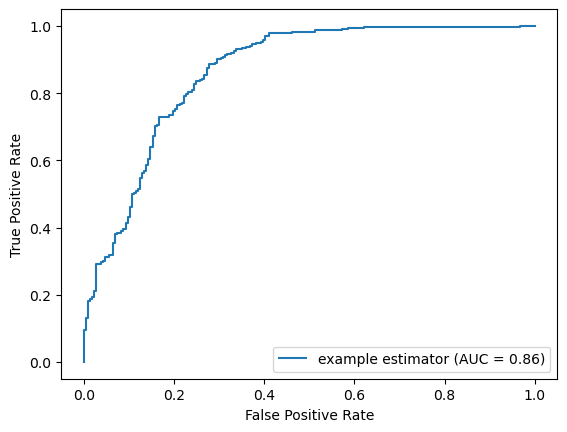

In [19]:
from sklearn.metrics import confusion_matrix

y_pred_seq, y_pred_tot = model.predict(x_test)

cm = confusion_matrix(y_test, y_pred_tot.round())

sepecifity = cm[1][1]/(cm[1][1]+cm[1][0])
sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
accuracy = (cm[1][1]+cm[0][0])/(cm[1][1]+cm[1][0]+cm[0][0]+cm[0][1])

ppv = cm[0][0]/(cm[0][0]+cm[1][0])
npv = cm[1][1]/(cm[1][1]+cm[0][1])

print('',sensitivity,'\n',sepecifity,'\n',ppv,'\n',npv,'\n',accuracy)
print(cm)

from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_tot, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()

In [8]:
models = []
model_partials = []
for i in range(0,2):
    models.append(get_model(1))
    models[i].load_weights(MODEL_DIR + 'turku-incepres_fold_0'+ str(i) +'.h5')
    model_partials.append(keras.models.Model(inputs=models[i].input, outputs=[models[i].layers[-2].output]))
    print(i)

2022-12-02 14:14:13.616834: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 14:14:15.774432: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11470 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:06:00.0, compute capability: 5.2


0
1


In [ ]:
import datetime
import gc

unique_ids = all_ids.StudyInstanceUID.unique()

IMG_TYPE = MASKED
IMAGE_PATH = '/home/shared/nps/imgs/'
BATCH_SIZE = 64

MAX = 2

for i in range(0,len(unique_ids)):
    exam_id = unique_ids[i]
    exam = all_ids[all_ids.StudyInstanceUID == exam_id]
    exam = exam.sort_values(by='ycoord')
    exam_generator = DataSliceGenerator(exam, 
                                   IMAGE_PATH, 
                                   img_type = IMG_TYPE,
                                   verbose=False, 
                                   set_type = 'test',
                                   shuffle=False,
                                   n_channels=1, 
                                   batch_size=1,
                                   dim=386)
    
    x_test = np.zeros([len(exam),386,386,1])
    for j in range(0,len(exam)):
        x_test[j],_ = exam_generator.__getitem__(j)
           
    feats = np.zeros([MAX, len(exam),64])
    results = np.zeros([MAX,len(exam),1])
    for j in range(int(len(exam)/BATCH_SIZE)):
        for k in range(0,MAX):
            feats[k, j*BATCH_SIZE:(j+1)*BATCH_SIZE] = np.array(model_partials[k](x_test[j*BATCH_SIZE:(j+1)*BATCH_SIZE]))
            results[k, j*BATCH_SIZE:(j+1)*BATCH_SIZE] = np.array(models[k](x_test[j*BATCH_SIZE:(j+1)*BATCH_SIZE]))
    if len(exam)%BATCH_SIZE != 0:
        for k in range(0,MAX):
            feats[k, (j+1)*BATCH_SIZE:] = np.array(model_partials[k](x_test[(j+1)*BATCH_SIZE:]))
            results[k, (j+1)*BATCH_SIZE:] = np.array(models[k](x_test[(j+1)*BATCH_SIZE:]))
        
    for k in range(0,MAX):
        exam['features'] = feats[k].tolist()
        exam['preds'] = results[k].tolist()
        np.save('/home/shared/nps/turku_0'+ str(k)+ '/' + exam_id, exam.to_dict(orient='records'))

    if i %10 == 0:
        print(i, 'time is: ', datetime.datetime.now())
        gc.collect()

2022-12-02 14:14:59.964577: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2022-12-02 14:15:02.156107: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


0 time is:  2022-12-02 14:15:31.179433
10 time is:  2022-12-02 14:19:06.563873
20 time is:  2022-12-02 14:22:42.424030
30 time is:  2022-12-02 14:26:06.339175
40 time is:  2022-12-02 14:29:41.777184
50 time is:  2022-12-02 14:32:30.859580
60 time is:  2022-12-02 14:36:10.401866
70 time is:  2022-12-02 14:39:39.737821
80 time is:  2022-12-02 14:42:51.417499
90 time is:  2022-12-02 14:45:45.100555
100 time is:  2022-12-02 14:48:16.059106
110 time is:  2022-12-02 14:50:56.812732
120 time is:  2022-12-02 14:54:16.228083
130 time is:  2022-12-02 14:57:18.604544
140 time is:  2022-12-02 15:00:14.739360
150 time is:  2022-12-02 15:03:08.525096
160 time is:  2022-12-02 15:06:05.575629
170 time is:  2022-12-02 15:08:58.887631
180 time is:  2022-12-02 15:12:00.515995
190 time is:  2022-12-02 15:14:56.175611
200 time is:  2022-12-02 15:17:46.050480
210 time is:  2022-12-02 15:20:57.897147
220 time is:  2022-12-02 15:23:34.181473
230 time is:  2022-12-02 15:26:26.961590
240 time is:  2022-12-02 15

In [ ]:
models = []
model_partials = []

MIN = 2
MAX = 5
for i in range(MIN,MAX):
    models.append(get_model(1))
    models[i-MIN].load_weights(MODEL_DIR + 'turku-incepres_fold_0'+ str(i) +'.h5')
    model_partials.append(keras.models.Model(inputs=models[i-MIN].input, outputs=[models[i-MIN].layers[-2].output]))
    print(i)
    
    
unique_ids = all_ids.StudyInstanceUID.unique()

IMG_TYPE = MASKED
IMAGE_PATH = '/home/shared/nps/imgs/'
BATCH_SIZE = 64

for i in range(0,len(unique_ids)):
    exam_id = unique_ids[i]
    exam = all_ids[all_ids.StudyInstanceUID == exam_id]
    exam = exam.sort_values(by='ycoord')
    exam_generator = DataSliceGenerator(exam, 
                                   IMAGE_PATH, 
                                   img_type = IMG_TYPE,
                                   verbose=False, 
                                   set_type = 'test',
                                   shuffle=False,
                                   n_channels=1, 
                                   batch_size=1,
                                   dim=386)
    
    x_test = np.zeros([len(exam),386,386,1])
    for j in range(0,len(exam)):
        x_test[j],_ = exam_generator.__getitem__(j)
           
    feats = np.zeros([MAX-MIN, len(exam),64])
    results = np.zeros([MAX-MIN,len(exam),1])
    for j in range(int(len(exam)/BATCH_SIZE)):
        for k in range(0,MAX-MIN):
            feats[k, j*BATCH_SIZE:(j+1)*BATCH_SIZE] = np.array(model_partials[k](x_test[j*BATCH_SIZE:(j+1)*BATCH_SIZE]))
            results[k, j*BATCH_SIZE:(j+1)*BATCH_SIZE] = np.array(models[k](x_test[j*BATCH_SIZE:(j+1)*BATCH_SIZE]))
    if len(exam)%BATCH_SIZE != 0:
        for k in range(0,MAX-MIN):
            feats[k, (j+1)*BATCH_SIZE:] = np.array(model_partials[k](x_test[(j+1)*BATCH_SIZE:]))
            results[k, (j+1)*BATCH_SIZE:] = np.array(models[k](x_test[(j+1)*BATCH_SIZE:]))
        
    for k in range(MIN,MAX):
        exam['features'] = feats[k-MIN].tolist()
        exam['preds'] = results[k-MIN].tolist()
        np.save('/home/shared/nps/turku_0'+ str(k)+ '/' + exam_id, exam.to_dict(orient='records'))

    if i %10 == 0:
        print(i, 'time is: ', datetime.datetime.now())
        gc.collect()

2
3
4
0 time is:  2022-12-03 19:24:03.967259
10 time is:  2022-12-03 19:27:50.867344
20 time is:  2022-12-03 19:31:44.469551
30 time is:  2022-12-03 19:35:40.729277
40 time is:  2022-12-03 19:39:43.032734
50 time is:  2022-12-03 19:42:57.965260
60 time is:  2022-12-03 19:47:21.485160
70 time is:  2022-12-03 19:51:38.390659
80 time is:  2022-12-03 19:55:45.362907
90 time is:  2022-12-03 19:59:13.773276
100 time is:  2022-12-03 20:02:33.682846
110 time is:  2022-12-03 20:05:58.601448
120 time is:  2022-12-03 20:10:11.698824
130 time is:  2022-12-03 20:14:04.185687
140 time is:  2022-12-03 20:17:38.397889
150 time is:  2022-12-03 20:20:59.264195
160 time is:  2022-12-03 20:24:37.974125
170 time is:  2022-12-03 20:28:19.174748
180 time is:  2022-12-03 20:32:04.380271
190 time is:  2022-12-03 20:35:44.163386
200 time is:  2022-12-03 20:39:27.069022


In [ ]:
# import datetime
# import gc

# models = []
# model_partials = []


# MIN = 5
# MAX = 8
# for i in range(MIN,MAX):
#     models.append(get_model(1))
#     models[i-MIN].load_weights(MODEL_DIR + 'turku-incepres_fold_0'+ str(i) +'.h5')
#     model_partials.append(keras.models.Model(inputs=models[i-MIN].input, outputs=[models[i-MIN].layers[-2].output]))
#     print(i)
    
directory = '/home/shared/nps/turku_05/'

lisdir = os.listdir(directory)
print('hello?')
print(len(lisdir))

files = pd.DataFrame({'file_name':lisdir})
files['StudyInstanceUID'] = files['file_name'].str.replace('.npy','')

remaining = all_ids[~all_ids.StudyInstanceUID.isin(files.StudyInstanceUID.unique())]
remaining = remaining.sort_values(by='StudyInstanceUID', ascending=False)

unique_ids = remaining.StudyInstanceUID.unique()[:20]

IMG_TYPE = MASKED
IMAGE_PATH = '/home/shared/nps/imgs/'
BATCH_SIZE = 64

for i in range(0,len(unique_ids)):
    exam_id = unique_ids[i]
    exam = all_ids[all_ids.StudyInstanceUID == exam_id]
    exam = exam.sort_values(by='ycoord')
    exam_generator = DataSliceGenerator(exam, 
                                   IMAGE_PATH, 
                                   img_type = IMG_TYPE,
                                   verbose=False, 
                                   set_type = 'test',
                                   shuffle=False,
                                   n_channels=1, 
                                   batch_size=1,
                                   dim=386)
    
    x_test = np.zeros([len(exam),386,386,1])
    for j in range(0,len(exam)):
        x_test[j],_ = exam_generator.__getitem__(j)
           
    feats = np.zeros([MAX-MIN, len(exam),64])
    results = np.zeros([MAX-MIN,len(exam),1])
    for j in range(int(len(exam)/BATCH_SIZE)):
        for k in range(0,MAX-MIN):
            feats[k, j*BATCH_SIZE:(j+1)*BATCH_SIZE] = np.array(model_partials[k](x_test[j*BATCH_SIZE:(j+1)*BATCH_SIZE]))
            results[k, j*BATCH_SIZE:(j+1)*BATCH_SIZE] = np.array(models[k](x_test[j*BATCH_SIZE:(j+1)*BATCH_SIZE]))
    if len(exam)%BATCH_SIZE != 0:
        for k in range(0,MAX-MIN):
            feats[k, (j+1)*BATCH_SIZE:] = np.array(model_partials[k](x_test[(j+1)*BATCH_SIZE:]))
            results[k, (j+1)*BATCH_SIZE:] = np.array(models[k](x_test[(j+1)*BATCH_SIZE:]))
        
    for k in range(MIN,MAX):
        exam['features'] = feats[k-MIN].tolist()
        exam['preds'] = results[k-MIN].tolist()
        np.save('/home/shared/nps/turku_0'+ str(k)+ '/' + exam_id, exam.to_dict(orient='records'))

    if i %10 == 0:
        print(i, 'time is: ', datetime.datetime.now())
        gc.collect()

hello?
6787
0 time is:  2022-12-06 11:41:10.238770
